# PCA Citi Surprise Index Backtest

This notebook will look at trading the DB G10 index using the raw PC values from the Citi Surprise Index

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"/Users/diegoalvarez/Desktop/research/FXCarryEconomicSurprise/root/src")
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FXCarryCitiSurprise\root\src")
from CitiPCA import PCAModel

## Initial Backtest

From a previous backtest ```IndexBacktest.ipynb``` it was shown that trading the DB Index conditioned on the raw value of the Citi Surprise Index. How well does it fare with the raw PC value. In this case combining multiple PCs can seem like a question of defining which weight to use. Normally a formalized model like OLS can be used, but taking the averages of each signal will be a simplistic approach. It may not be clear how many principal components are needed, in this case there are 13 of them. A very naive approach will be to make 13 models. Each model will include another principal component, therefore the first model is the first PC, the third is first 3 PCs, and the 13th is all of them.

In [3]:
def _lag_value(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(lag_value = lambda x: x.value.shift()).
        dropna())
    
    return df_out

def get_signal() -> pd.DataFrame: 

    df_signal = (PCAModel().pca().drop(
        columns = ["explained_variance_ratio"]).
        groupby("pc").
        apply(_lag_value).
        reset_index(drop = True))

    df_out = pd.DataFrame()

    pcs = df_signal.pc.drop_duplicates().sort_values().to_list()
    for i in range(len(pcs)):

        tmp_pcs = ["PC{}".format(j + 1) for j in range(i + 1)]
        df_tmp  = (df_signal.query(
            "pc == @tmp_pcs").
            pivot(index = "date", columns = "pc", values = "lag_value").
            mean(axis = 1).
            to_frame(name = "signal").
            assign(port = str(i + 1) + "PCs"))

        df_out = pd.concat([df_out, df_tmp])
        
    return df_out

df_signal = get_signal()

In [4]:
def get_signal_rtn(df_signal: pd.DataFrame) -> pd.DataFrame: 
    
    keep_groups = "FXCARRSP"

    df_out = (PCAModel().get_misc_indices().query(
        "security == @keep_groups")
        [["date", "security", "rtn"]].
        pivot(index = "date", columns = "security", values = "rtn").
        merge(right = df_signal, how = "inner", on = ["date"]).
        assign(signal_rtn = lambda x: np.sign(x.signal) * x.FXCARRSP))
    
    return df_out

df_signal_rtn = get_signal_rtn(df_signal)

## Initial Performance

The initial performance isn't great. In this case the returns are quite sporadic, although a lot of the strategies beat out the underlying index. 

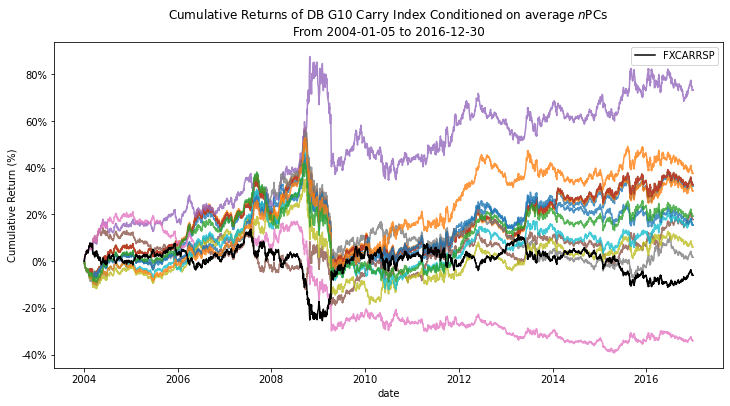

In [5]:
def plot_initial_backtest(df_signal_rtn: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(figsize = (12,6))

    (df_signal_rtn.reset_index().pivot(
        index = "date", columns = "port", values = "signal_rtn").
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            legend = False,
            alpha  = 0.8,
            ax     = axes,
            ylabel = "Cumulative Return (%)",
            title  = r"Cumulative Returns of DB G10 Carry Index Conditioned on average $n$" + "PCs\nFrom {} to {}".format(
                df_signal_rtn.index.min(),
                df_signal_rtn.index.max())))
    
    dates = df_signal_rtn.index.to_list()
    
    (PCAModel().get_misc_indices().query(
        "security == 'FXCARRSP'").
        query("date == @dates").
        rename(columns = {"security": ""}).
        pivot(index = "date", columns = "", values = "rtn").
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax = axes,
            color = "black"))

    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    
plot_initial_backtest(df_signal_rtn)

The first question to ask, is if there is a relationship between the number of components used and its results.

In [6]:
def get_sharpe(df_signal_rtn: pd.DataFrame) -> pd.DataFrame: 
    
    keep_groups = "FXCARRSP"

    df_benchmark = (PCAModel().get_misc_indices().query(
        "security == @keep_groups")
        [["security", "rtn"]].
        groupby("security").
        agg(["mean", "std"])
        ["rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index()
        [["security", "sharpe"]].
        rename(columns = {"security": "num_pcs"}))

    df_pcs_sharpe = (df_signal_rtn[
        ["port", "signal_rtn"]].
        reset_index(drop = True).
        groupby("port").
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        reset_index().
        assign(
            num_pcs = lambda x: x.port.str.replace("PCs", "").astype(int),
            sharpe  = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["num_pcs", "sharpe"]])

    df_sharpe = pd.concat([df_pcs_sharpe.sort_values("num_pcs"), df_benchmark])
    return df_sharpe

df_sharpe = get_sharpe(df_signal_rtn)

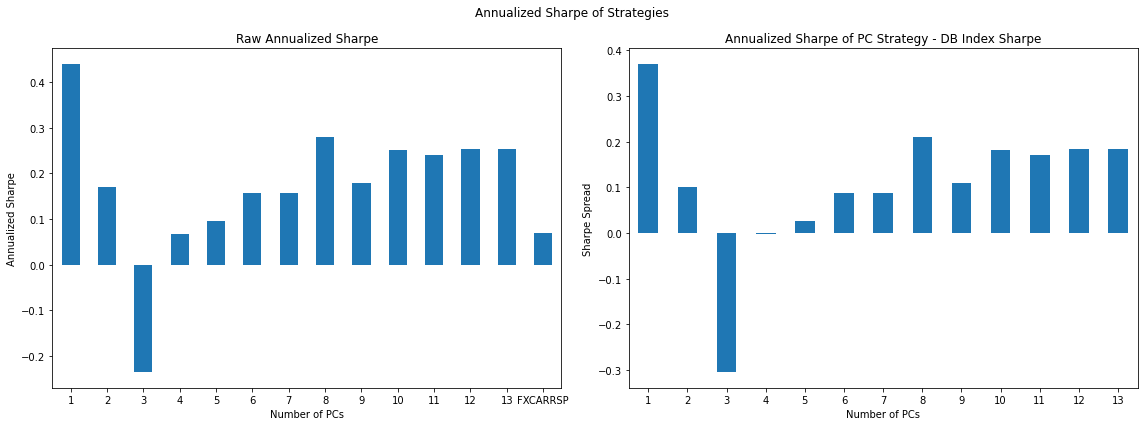

In [7]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(ncols = 2, figsize = (16,6))

    (df_sharpe.set_index(
        "num_pcs").
        plot(
            kind   = "bar",
            rot    = 0,
            ax     = axes[0],
            legend = False,
            ylabel = "Annualized Sharpe",
            title  = "Raw Annualized Sharpe",
            xlabel = "Number of PCs"))

    (df_sharpe.set_index(
        "num_pcs").
        T.
        melt(id_vars = ["FXCARRSP"]).
        assign(sharpe_spread = lambda x: x.value - x.FXCARRSP).
        set_index("num_pcs")
        [["sharpe_spread"]].
        plot(
            rot    = 0,
            kind   = "bar",
            ax     = axes[1],
            legend = False,
            xlabel = "Number of PCs",
            ylabel = "Sharpe Spread",
            title  = "Annualized Sharpe of PC Strategy - DB Index Sharpe"))

    fig.suptitle("Annualized Sharpe of Strategies")
    plt.tight_layout()
    
plot_sharpe(df_sharpe)

In this case there isn't a clear sign that adding in principal components generates greater return. An argument could be constructed that the second and third principal component's raw value decrease the portfolio's sharpe and while PCs 4-13 do. Such an argument is "cherry-picked" and will likely lead to overfitting, and it intuitively goes against the idea of principal components. 

What is of interest is that the while all sharpes outperform their underling benchmark other than trading the first 3 principal components.

## Scenario Analysis

In this case start by analyzing generate 3 sets of returns from the 13 portfolios. In this case take the median performance and average performance. Ideally getting a worst and best case would be nice, but both explode to positive and negative extremes.

In [8]:
def get_scenarios(df_signal: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df_signal_rtn.reset_index()[
        ["date", "signal_rtn"]].
        groupby("date").
        agg(["median", "mean"])
        ["signal_rtn"].
        rename(columns = {
            "median": "Median",
            "mean"  : "Average"}))
    
    return df_out

df_scenario = get_scenarios(df_signal)

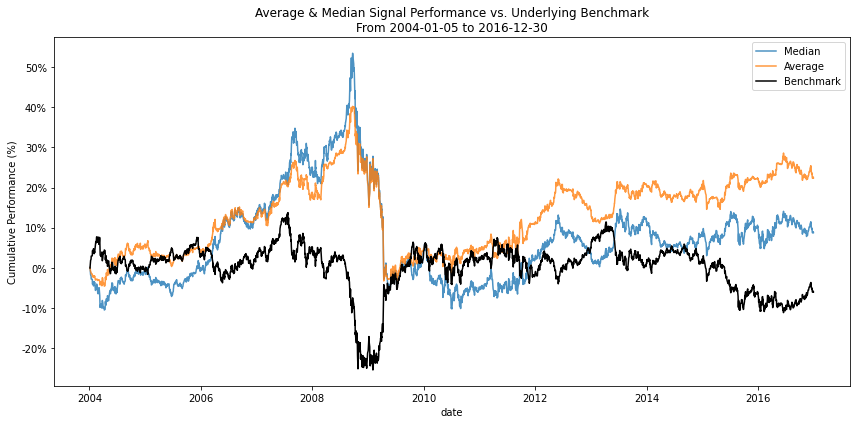

In [9]:
def plot_mean_median_performance(df_scenario: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(figsize = (12,6))

    (df_scenario.apply(
        lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax = axes,
            ylabel = "Cumulative Performance (%)",
            alpha  = 0.8))

    keep_groups = "FXCARRSP"
    dates       = df_scenario.index.to_list()

    (PCAModel().get_misc_indices().query(
        "security == @keep_groups").
        query("date == @dates").
        set_index("date")
        [["rtn"]].
        rename(columns = {"rtn": "Benchmark"}).
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax    = axes,
            color = "black",
            title = "Average & Median Signal Performance vs. Underlying Benchmark\nFrom {} to {}".format(
                df_scenario.index.min(),
                df_scenario.index.max())))

    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    plt.tight_layout()
    
plot_mean_median_performance(df_scenario)

In [10]:
def get_sharpe(df_scenario: pd.DataFrame) -> pd.DataFrame: 
    
    keep_groups = ["FXCARRSP"]
    
    df_sharpe = (PCAModel().get_misc_indices().query(
        "security == @keep_groups").
        pivot(index = "date", columns = "security", values = "rtn").
        merge(right = df_scenario, how = "inner", on = ["date"]).
        reset_index().
        melt(id_vars = "date").
        drop(columns = ["date"]).
        groupby("variable").
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)))
    
    return df_sharpe

df_sharpe = get_sharpe(df_scenario)

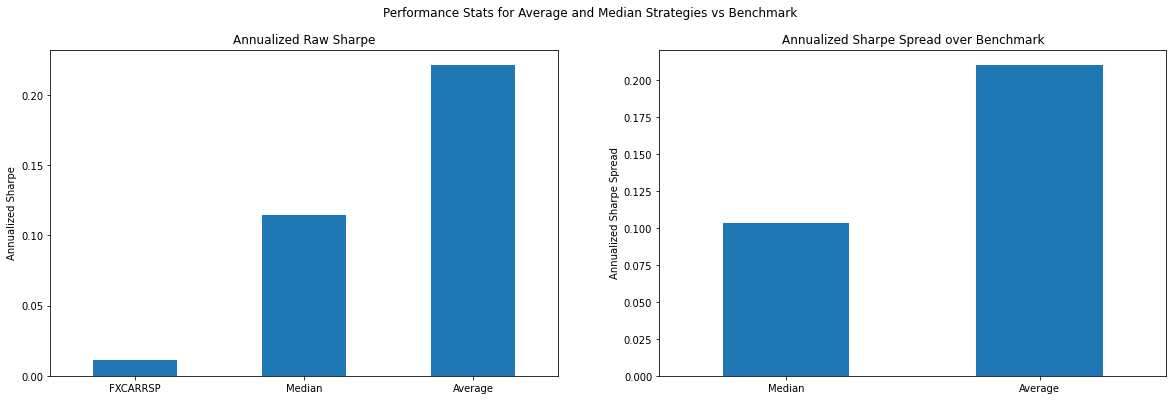

In [11]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    (df_sharpe[
        ["sharpe"]].
        sort_values("sharpe").
        plot(
            ax     = axes[0],
            kind   = "bar",
            legend = False,
            rot    = 0,
            xlabel = "",
            ylabel = "Annualized Sharpe",
            title  = "Annualized Raw Sharpe"))

    (df_sharpe[
        ["sharpe"]].
        T.
        melt(id_vars = "FXCARRSP").
        assign(sharpe_spread = lambda x: x.value - x.FXCARRSP).
        set_index("variable")
        [["sharpe_spread"]].
        sort_values("sharpe_spread").
        plot(
            ax     = axes[1],
            kind   = "bar",
            xlabel = "",
            rot    = 0,
            legend = False,
            ylabel = "Annualized Sharpe Spread",
            title  = "Annualized Sharpe Spread over Benchmark"))
    
    fig.suptitle("Performance Stats for Average and Median Strategies vs Benchmark")
    
plot_sharpe(df_sharpe)

## An Investigation for bad signals

Looking at the raw PCs there is a chance that the PC signals has reflected (meaning that it should be shorted rather than be long). Start by trading those sole signals (2 & 3). 

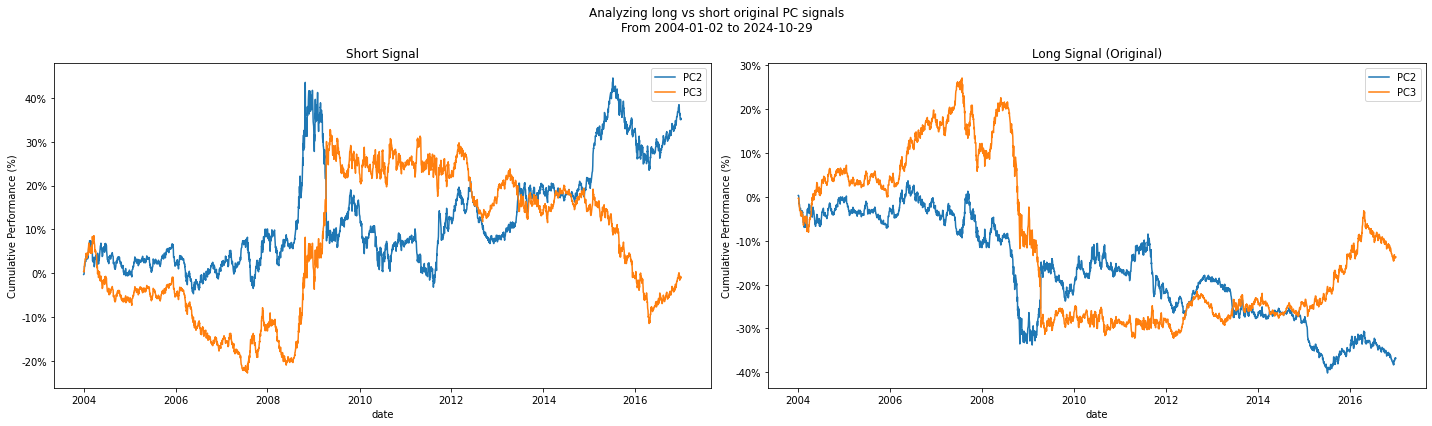

In [12]:
def plot_compare_sign() -> plt.Figure: 
    
    keep_pcs = ["PC2", "PC3"]

    df_tmp = (PCAModel().pca().drop(
        columns = ["explained_variance_ratio"]).
        query("pc == @keep_pcs"))

    keep_groups = "FXCARRSP"
    indicators = {
        -1: "Short Signal",
         1: "Long Signal (Original)"}

    fig, axes = plt.subplots(ncols = len(indicators.keys()), figsize = (20,6))

    for indicator, ax in zip(indicators.keys(), axes.flatten()): 

        (PCAModel().get_misc_indices().query(
            "security == @keep_groups")
            [["date", "security", "rtn"]].
            pivot(index = "date", columns = "security", values = "rtn").
            merge(right = df_tmp, how = "inner", on = ["date"]).
            assign(signal_rtn = lambda x: indicator * np.sign(x.value) * x.FXCARRSP).
            rename(columns = {"pc": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                title  = indicators[indicator],
                ylabel = "Cumulative Performance (%)"))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))

    fig.suptitle("Analyzing long vs short original PC signals\nFrom {} to {}".format(
        df_tmp.date.min(),
        df_tmp.date.max()))

    plt.tight_layout()
    
plot_compare_sign()